In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import statsmodels.graphics.tsaplots as sgt
import statsmodels.stats.diagnostic as smsdia
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import numpy as np
import matplotlib.dates as mdates
from IPython.display import display
from matplotlib import gridspec

sns.set()
plt.rc('font', family='NanumGothic')
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
data_path = "./data/blood_donation_data.xlsx"
xlsx = pd.ExcelFile(data_path)
# print(xlsx.sheet_names)

numb_of_bd_df = pd.read_excel(xlsx, "헌혈자 수")
bd_month_df = pd.read_excel(xlsx, "월별 헌혈통계")
bd_method_df = pd.read_excel(xlsx, "헌혈방법별 헌혈통계")
bd_btype_df = pd.read_excel(xlsx, "혈액형별 헌혈통계")
bd_age_df = pd.read_excel(xlsx, "연령별 헌혈통계", header=[0, 1])
bd_job_df = pd.read_excel(xlsx, "직업별 헌혈통계")
bs_day_df = pd.read_excel(xlsx, "수혈용 혈액 보유 추이")
bs_month_type_df = pd.read_excel(xlsx, "수혈용 혈액 월평균 보유 추이", header=[0, 1])
bd_location_df = pd.read_excel(xlsx, "장소별 헌혈통계")
bs_method_df = pd.read_excel(xlsx, "제제별 수혈용 혈액 공급실적")
rejection_reason_df = pd.read_excel(xlsx, "사유별 헌혈 부적격", header=[0, 1])
test_fail_df = pd.read_excel(xlsx, "혈액 검사 부적격")
region_population_df = pd.read_excel(xlsx, "지역별 인구")
xlsx.close()

In [3]:
# preprocess data

# 월별 헌혈통계
bd_month_df = pd.melt(bd_month_df, id_vars=bd_month_df.columns[:3], value_vars=bd_month_df.columns[3:], var_name="year",
                      value_name="count")
bd_month_df["date"] = pd.to_datetime(bd_month_df["year"].astype(str) + "-" + bd_month_df["month"].astype(str))

bd_method_df = bd_method_df.melt(id_vars=bd_method_df.columns[:3], value_vars=bd_method_df.columns[3:],
                                 var_name="method", value_name="count")
bd_method_df.to_csv("./output/summarized/monthly.csv", encoding="utf8", index=False)

# 혈액형별 헌혈통계
bd_btype_df = bd_btype_df.melt(id_vars=bd_btype_df.columns[:3], value_vars=bd_btype_df.columns[3:], var_name="year",
                               value_name="count")
bd_btype_df.to_csv("./output/summarized/blood_type.csv", encoding="utf8", index=False)

# 연령별 헌혈통계
bd_age_df.columns = bd_age_df.columns.map("_".join)
bd_age_df.columns.values[:2] = ["region", "gender"]
bd_age_df = bd_age_df.melt(id_vars=bd_age_df.columns[:2], value_vars=bd_age_df.columns[2:], var_name="year_ageband",
                           value_name="count")
bd_age_df.to_csv("./output/summarized/age.csv", encoding="utf8", index=False)

bd_age_df[["year", "age_band"]] = bd_age_df["year_ageband"].str.split("_", expand=True)
bd_age_df["year"] = bd_age_df["year"].astype("int")
bd_age_df = bd_age_df.drop("year_ageband", axis=1)
bd_age_df.to_csv("./output/summarized/age.csv", encoding="utf8", index=False)

# 직업별 헌혈통계
bd_job_df = bd_job_df.melt(id_vars=bd_job_df.columns[:3], value_vars=bd_job_df.columns[3:], var_name="year",
                           value_name="count")
bd_job_df.to_csv("./output/summarized/job.csv", encoding="utf8", index=False)

# 수혈용 혈액 일별 보유 추이
bs_day_df = pd.melt(bs_day_df, id_vars=bs_day_df.columns[0], value_vars=bs_day_df.columns[1:], var_name="year",
                    value_name="count")
bs_day_df["date"] = pd.to_datetime(
    bs_day_df["year"].astype(str) + "-" + bs_day_df["month_day"][bs_day_df["month_day"] != "02-29"])

# 수혈용 혈액 월평균 보유 추이
bs_month_type_df.columns = bs_month_type_df.columns.map("_".join)
bs_month_type_df.columns.values[0] = "month"
bs_month_type_df = bs_month_type_df.melt(id_vars=[bs_month_type_df.columns[0]], value_vars=bs_month_type_df.columns[1:],
                                         var_name="year_type", value_name="count")
bs_month_type_df[["year", "type"]] = bs_month_type_df["year_type"].str.split("_", expand=True)
bs_month_type_df["year"] = bs_month_type_df["year"].astype("int")
bs_month_type_df["date"] = pd.to_datetime(
    bs_month_type_df["year"].astype(str) + "-" + bs_month_type_df["month"].astype(str))
bs_month_type_df = bs_month_type_df.drop("year_type", axis=1)

# 장소별 헌혈통계
bd_location_df = pd.melt(bd_location_df, id_vars=bd_location_df.columns[:4], value_vars=bd_location_df.columns[4:],
                         var_name="year", value_name="count")
bd_location_df.to_csv("./output/summarized/location.csv", encoding="utf8", index=False)

# 제제별 수혈용 혈액 공급실적
bs_method_df = pd.melt(bs_method_df, id_vars=bs_method_df.columns[:3], value_vars=bs_method_df.columns[3:],
                       var_name="year", value_name="count")

# 사유별 헌혈 부적격
rejection_reason_df.columns = rejection_reason_df.columns.map("_".join)
rejection_reason_df.columns.values[0] = "month"
rejection_reason_df = rejection_reason_df.melt(id_vars=rejection_reason_df.columns[0],
                                               value_vars=rejection_reason_df.columns[1:], var_name="year_reason",
                                               value_name="count")
rejection_reason_df[["year", "reason"]] = rejection_reason_df["year_reason"].str.split("_", expand=True)
rejection_reason_df["year"] = rejection_reason_df["year"].astype("int")
rejection_reason_df = rejection_reason_df.drop("year_reason", axis=1)
rejection_reason_gender_df = rejection_reason_df[rejection_reason_df["month"].str.contains("남|여", na=False)]
rejection_reason_gender_df = rejection_reason_gender_df.rename(columns={"month": "gender"})
rejection_reason_month_df = rejection_reason_df[~rejection_reason_df["month"].str.contains("남|여", na=False)]
rejection_reason_month_df["date"] = pd.to_datetime(
    rejection_reason_month_df["year"].astype(str) + "-" + rejection_reason_month_df["month"].astype(str))
rejection_reason_month_df.to_csv("./output/summarized/rejection_reason.csv", encoding="utf8", index=False)

# 혈액 검사 부적격
test_fail_df = pd.melt(test_fail_df, id_vars=test_fail_df.columns[:1], value_vars=test_fail_df.columns[1:],
                       var_name="reason", value_name="count")

# 지역별 인구
region_population_df = pd.melt(region_population_df, id_vars=region_population_df.columns[:1],
                               value_vars=region_population_df.columns[1:], var_name="year", value_name="count")

C:\Users\dgkim\AppData\Local\Temp\ipykernel_15444\1568537385.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rejection_reason_month_df["date"] = pd.to_datetime(


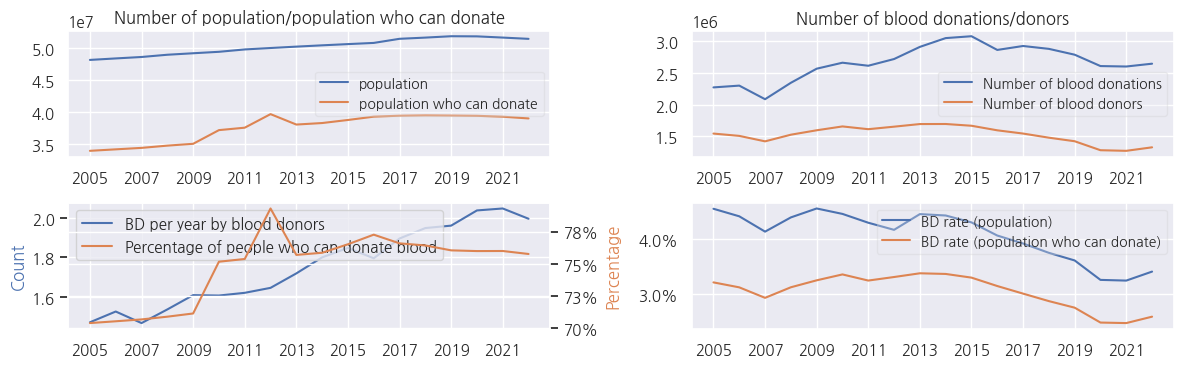

In [4]:
_, axs = plt.subplots(2, 2, figsize=(12, 4))

# 인구 / 헌혈 가능 인구
axs[0, 0].plot(numb_of_bd_df["year"], numb_of_bd_df["population"], label="population")
axs[0, 0].plot(numb_of_bd_df["year"], numb_of_bd_df["blood donor population"], label="population who can donate")
axs[0, 0].set_title("Number of population/population who can donate")
axs[0, 0].legend(loc=5, fontsize=10, framealpha=0.3)

# 헌혈 건수 / 헌혈자 수
axs[0, 1].plot(numb_of_bd_df["year"], numb_of_bd_df["blood donation count"], label="Number of blood donations")
axs[0, 1].plot(numb_of_bd_df["year"], numb_of_bd_df["blood donor count"], label="Number of blood donors")
axs[0, 1].set_title("Number of blood donations/donors")
axs[0, 1].legend(loc=5, fontsize=10, framealpha=0.3)

# 헌혈자 1인당 연간 헌혈 횟수 / 헌혈가능인구 비율
lns1 = axs[1, 0].plot(numb_of_bd_df["year"],
                      (numb_of_bd_df["blood donation count"] / numb_of_bd_df["blood donor count"]),
                      label="BD per year by blood donors", color="C0")
ax = axs[1, 0].twinx()
lns2 = ax.plot(numb_of_bd_df["year"], (numb_of_bd_df["blood donor population"] / numb_of_bd_df["population"]),
               label="Percentage of people who can donate blood", color="C1")
lns = lns1 + lns2
axs[1, 0].legend(lns, [l.get_label() for l in lns])
axs[1, 0].set_ylabel("Count", color="C0")
ax.set_ylabel("Percentage", color="C1")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# 전국민대상 / 헌혈가능인구대상 헌혈률
axs[1, 1].plot(numb_of_bd_df["year"], (numb_of_bd_df["blood donor count"] / numb_of_bd_df["blood donor population"]),
               label="BD rate (population)")
axs[1, 1].plot(numb_of_bd_df["year"], (numb_of_bd_df["blood donor count"] / numb_of_bd_df["population"]),
               label="BD rate (population who can donate)")
axs[1, 1].legend(loc=1, fontsize=10, framealpha=0.3)
axs[1, 1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

for ax in axs.flatten():
    ax.set_xticks(range(2005, 2022 + 1, 2))

plt.tight_layout()
plt.show()

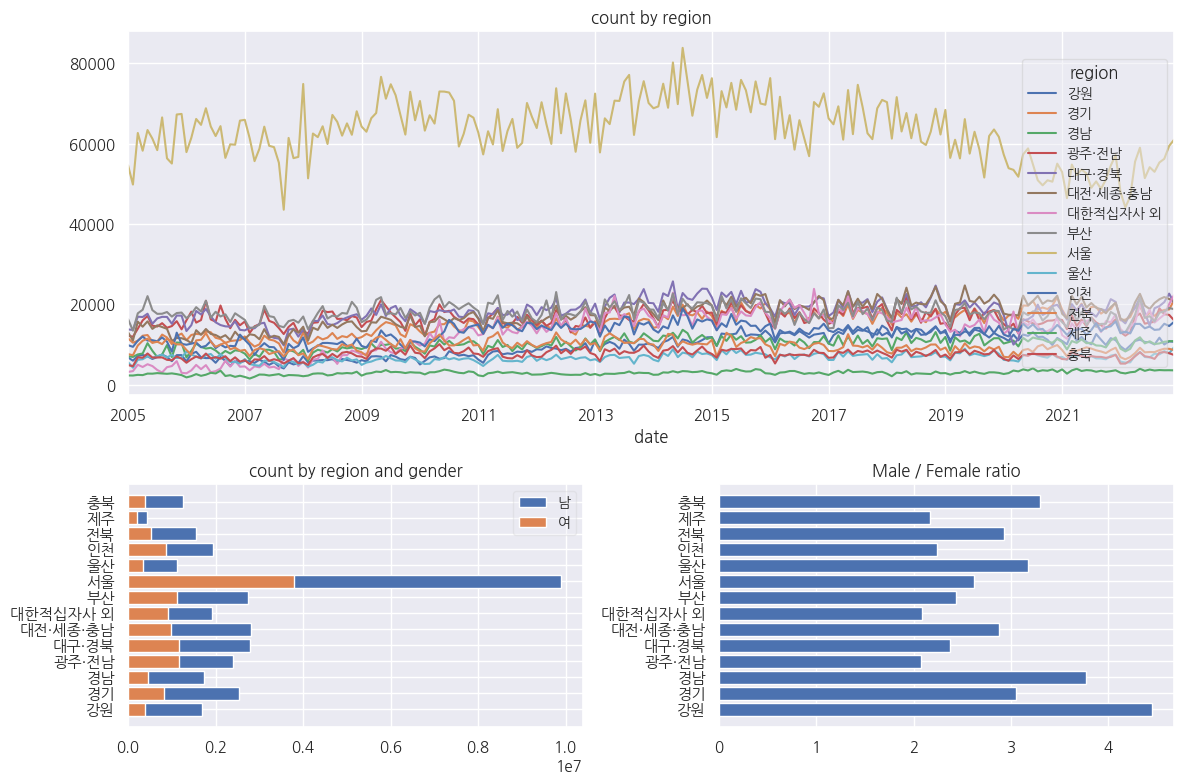

In [64]:
bd_month_processed_df = bd_month_df.copy()
seoul_region_dict = {"서울남부": "서울", "서울동부": "서울", "서울서부": "서울", "서울중앙": "서울"}
bd_month_processed_df['region'] = bd_month_processed_df['region'].replace(seoul_region_dict)

bd_year_processed_df = bd_month_processed_df.copy()
bd_year_processed_df['date'] = pd.to_datetime(bd_year_processed_df['date']).dt.to_period('Y')

fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[1.5, 1])

ax = fig.add_subplot(gs[0, :])
bd_group = bd_month_processed_df.groupby(by=["date", "region"])["count"].sum().unstack()
bd_group.plot.line(title="count by region", ax=ax)
ax.legend(title='region', loc=5, fontsize=10, framealpha=0.5)

ax = fig.add_subplot(gs[1, 0])
bd_group = bd_month_processed_df.groupby(by=["region", "gender"])["count"].sum().unstack()
ax.barh(bd_group["남"].index, bd_group["남"], label="남")
ax.barh(bd_group["여"].index, bd_group["여"], label="여")
ax.set_title("count by region and gender")
ax.legend(loc=1, fontsize=10, framealpha=0.3)

ax = fig.add_subplot(gs[1, 1])
ax.barh(bd_group.index, (bd_group["남"].values / bd_group["여"].values))
ax.set_title("Male / Female ratio")

plt.tight_layout()
plt.show()

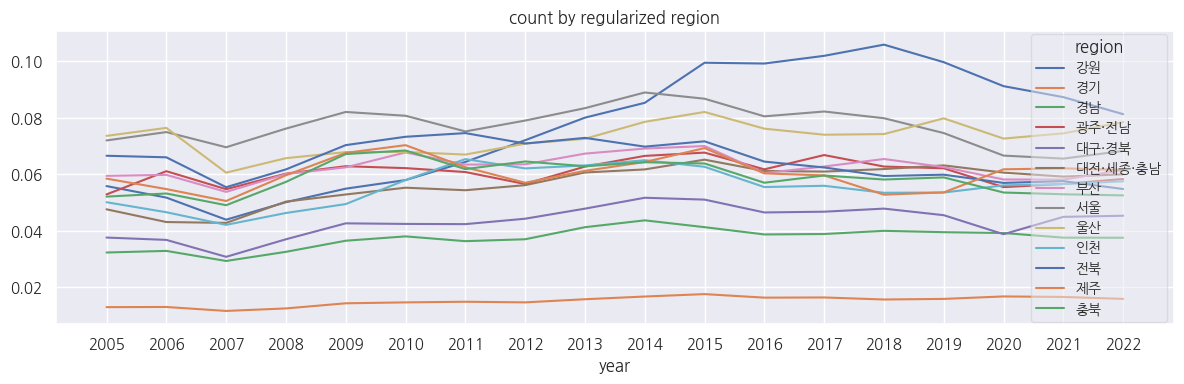

In [65]:
# 지역별 인구수로 정규화 한 헌혈자 수
regularized_bd_month_df = bd_month_processed_df.groupby(by=["year", "region"])["count"].sum().unstack().reset_index().copy()
regularized_bd_month_df = regularized_bd_month_df.drop("대한적십자사 외", axis=1)

for column in regularized_bd_month_df.columns[1:]:
    region_population_hist_df = region_population_df[region_population_df["region"] == column]["count"].reset_index(drop=True)
    regularized_bd_month_df[column] = regularized_bd_month_df[column]/region_population_hist_df
regularized_bd_month_df = regularized_bd_month_df.set_index("year")

_, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
regularized_bd_month_df.plot.line(title="count by regularized region", ax=ax)
ax.set_xticks(range(2005, 2022 + 1))
ax.legend(title='region', loc=5, fontsize=10, framealpha=0.5)
plt.tight_layout()
plt.show()
# TODO: 각 지역의 인구통계가 있다면 잠재 헌혈자수를 도출 가능할것으로 보임 (연령x직업x성별 인구통계, 헌혈의집 수?)

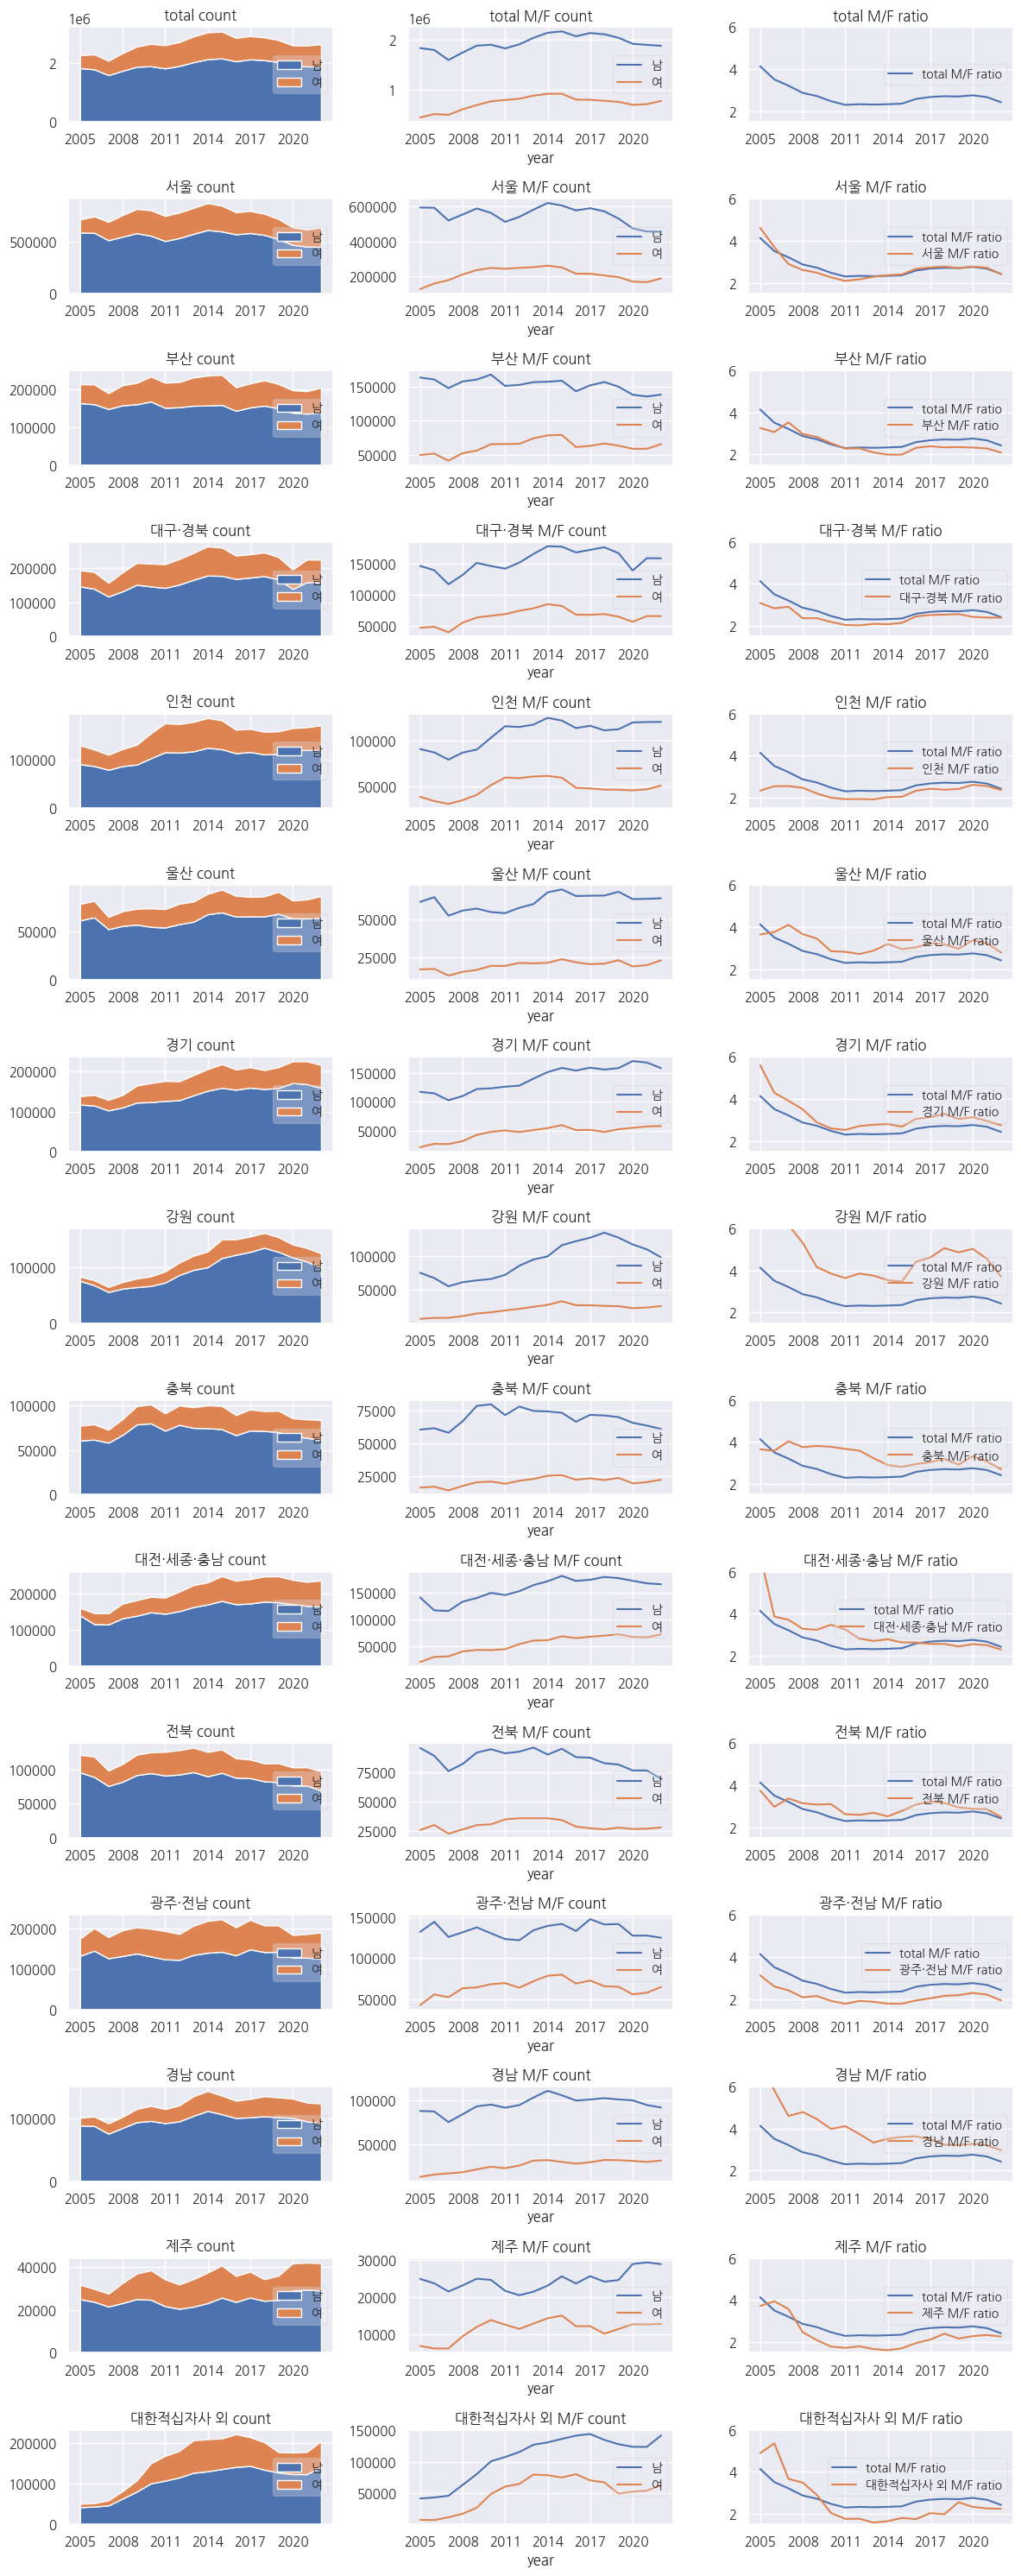

In [66]:
regions = bd_month_processed_df["region"].unique()
_, axs = plt.subplots(nrows=len(regions)+1, ncols=3, figsize=(12, 30))

for i, axs_row in enumerate(axs):
    region = "total" if i == 0 else regions[i-1]
    region_group = bd_month_processed_df if i == 0 else bd_month_processed_df[bd_month_processed_df["region"]==region]
    region_group = region_group.groupby(by=["year", "gender"])["count"].sum()
    male_series = region_group.xs("남", level="gender")
    female_series = region_group.xs("여", level="gender")
    axs[i, 0].stackplot(male_series.index, male_series, female_series, labels=["남", "여"])
    axs[i, 0].set_title(f"{region} count")
    region_group.unstack().plot.line(title=f"{region} M/F count", ax=axs[i, 1])
    mf_ratio = (male_series / female_series)
    if i ==0:
        for ax in axs[:, 2]:
            ax.plot(mf_ratio, label="total M/F ratio")
    else:
        axs[i, 2].plot(mf_ratio, label=f"{region} M/F ratio")
    axs[i, 2].set_title(f"{region} M/F ratio")
    axs[i, 2].set_ylim([1.5, 6])

    for j, ax in enumerate(axs_row):
        ax.set_xticks(range(2005, 2022 + 1, 3))
        ax.legend(loc=5, fontsize=10, framealpha=0.3)

plt.tight_layout()
plt.show()

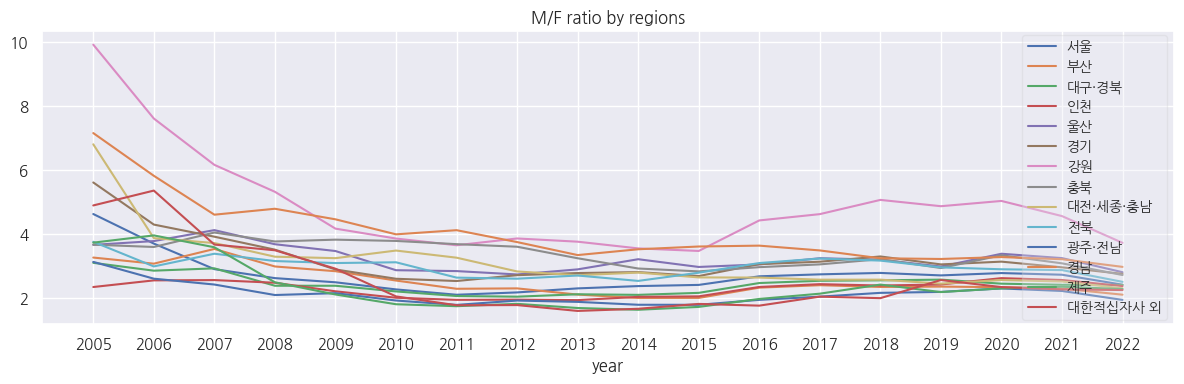

In [49]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

for i, region in enumerate(regions):
    region_group = bd_month_processed_df[bd_month_processed_df["region"]==region].groupby(by=["year", "gender"])["count"].sum()
    male_series = region_group.xs("남", level="gender")
    female_series = region_group.xs("여", level="gender")
    mf_ratio = (male_series / female_series)
    mf_ratio.plot.line(ax=ax, label=region)

ax.legend(loc=5, fontsize=10, framealpha=0.3)
ax.set_title("M/F ratio by regions")
ax.set_xticks(range(2005, 2022 + 1))
plt.tight_layout()
plt.show()

KS test p-value of resid: 0.86


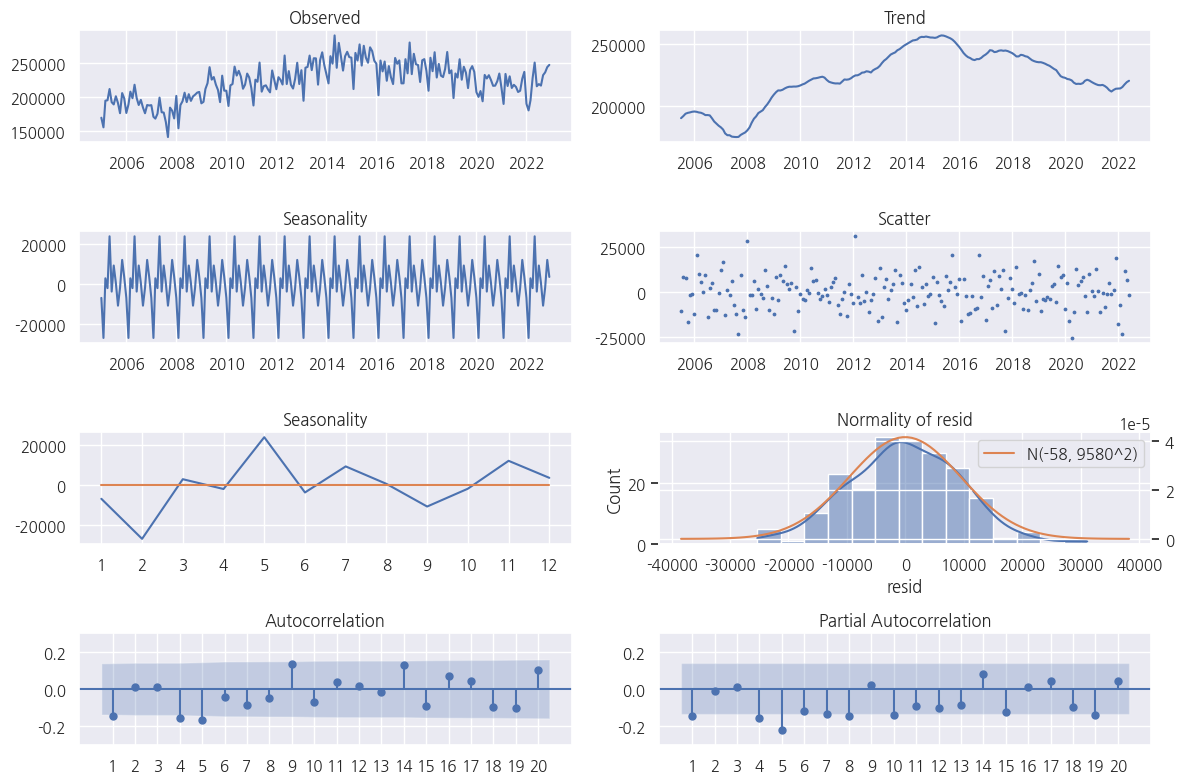

In [50]:
_, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 8))

bd_group = bd_month_processed_df.groupby(by=["date"])["count"].sum()
result = seasonal_decompose(bd_group, model="additive", period=12)
axs[0, 0].plot(result.observed)
axs[0, 1].plot(result.trend)
axs[1, 0].plot(result.seasonal)
axs[1, 1].scatter(bd_group.index, result.resid, s=3)

for i, plot_name in enumerate(["Observed", "Trend", "Seasonality", "Scatter"]):
    axs.flatten()[i].set_title(plot_name)

x_range = range(1, 12 + 1)
axs[2, 0].plot(x_range, result.seasonal[0:12])
axs[2, 0].plot(x_range, [0]*len(x_range))
axs[2, 0].set_xticks(x_range)
axs[2, 0].set_title("Seasonality")

resid = result.resid.dropna()
sns.histplot(resid, kde=True, ax=axs[2, 1])
ax = axs[2, 1].twinx()
mu, std = stats.norm.fit(resid.fillna(0))
x_range = np.linspace(mu-std*4, mu+std*4, 100)
ax.plot(x_range, stats.norm.pdf(x_range, mu, std), c="C1", label=f"N({int(mu)}, {int(std)}^2)")
axs[2, 1].set_title("Normality of resid")
ax.legend()

_, ks_p = smsdia.kstest_normal(resid)
print(f"KS test p-value of resid: {ks_p:.2f}")

sgt.plot_acf(resid, lags=20, zero=False, ax=axs[3, 0])
sgt.plot_pacf(resid, lags=20, zero=False, ax=axs[3, 1])
for ax in axs[3]:
    ax.set_ylim([-0.3, 0.3])
    ax.set_xticks(range(1, 20 + 1))

plt.tight_layout()
plt.show()

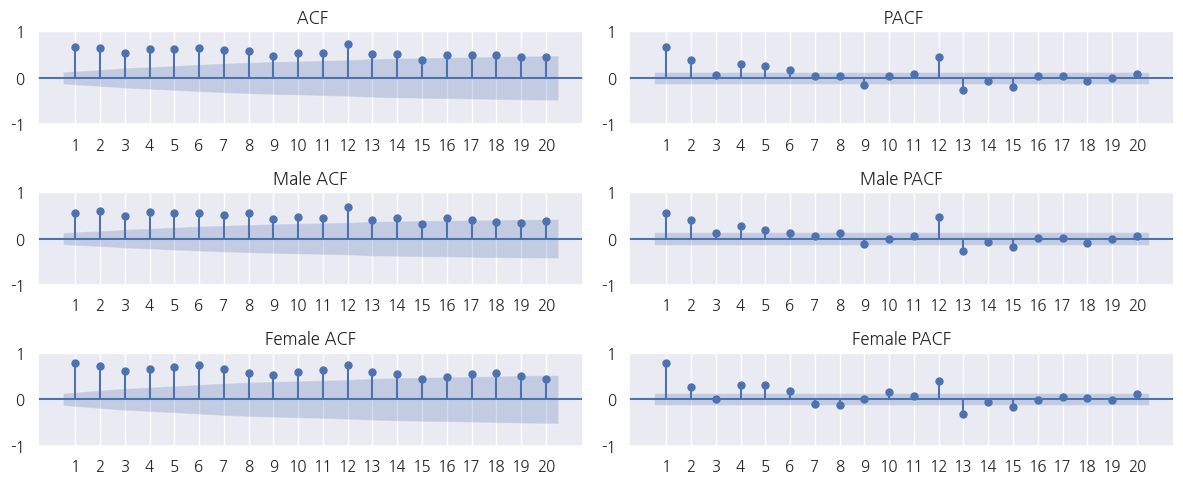

In [643]:
bd_group = bd_month_processed_df.groupby(by=["date"])["count"].sum()

_, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 5))

sgt.plot_acf(bd_group, lags=20, zero=False, ax=axs[0, 0])
sgt.plot_pacf(bd_group, lags=20, zero=False, ax=axs[0, 1])

bd_group = bd_month_processed_df.groupby(by=["date", "gender"])["count"].sum()

male_series = bd_group.xs("남", level="gender")
sgt.plot_acf(male_series, lags=20, zero=False, ax=axs[1, 0])
sgt.plot_pacf(male_series, lags=20, zero=False, ax=axs[1, 1])

female_series = bd_group.xs("여", level="gender")
sgt.plot_acf(female_series, lags=20, zero=False, ax=axs[2, 0])
sgt.plot_pacf(female_series, lags=20, zero=False, ax=axs[2][1])

for i, text in enumerate(["", "Male", "Female"]):
    axs[i][0].set_title(f"{text} ACF")
    axs[i][1].set_title(f"{text} PACF")

for ax in axs.flatten():
    ax.set_xticks(range(1, 20 + 1))

plt.tight_layout()
plt.show()

KS test p-value of resid: 0.03


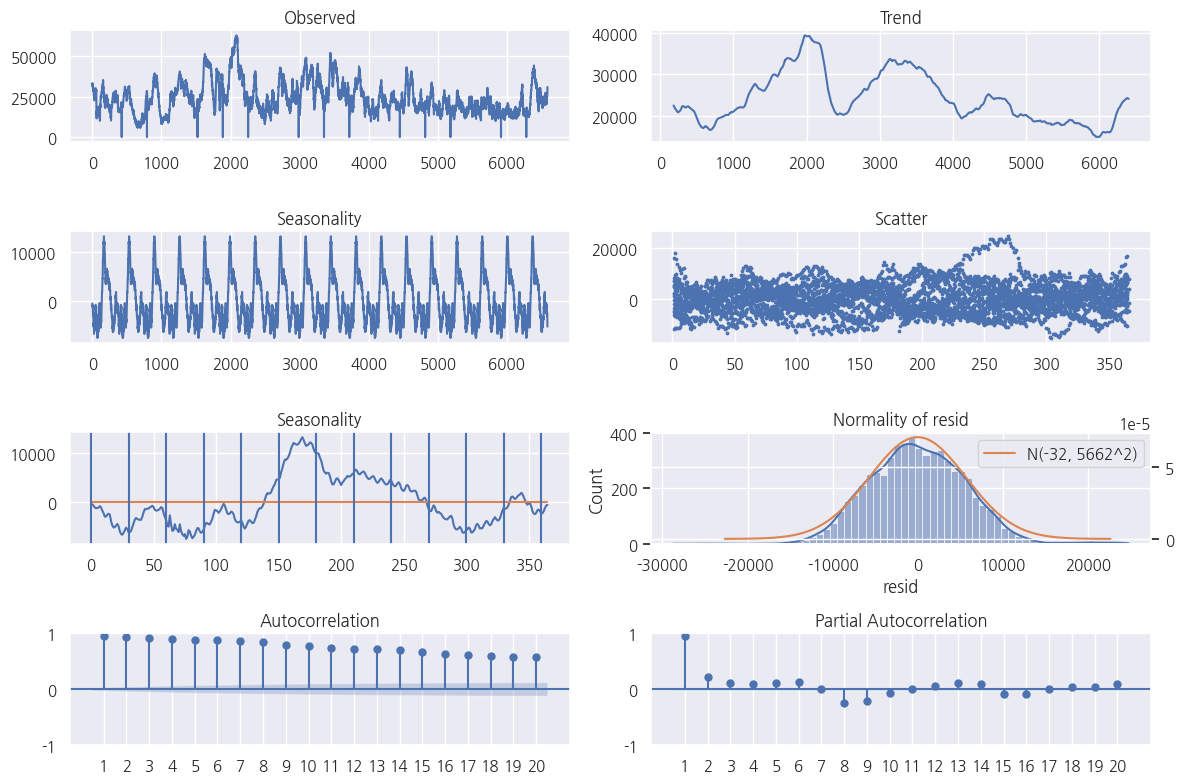

In [666]:
# 수혈용 혈액 일간 보유 추이
_, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 8))

result = seasonal_decompose(bs_day_df["count"], model="additive", period=365)
axs[0, 0].plot(result.observed)
axs[0, 1].plot(result.trend)
axs[1, 0].plot(result.seasonal)
axs[1, 1].scatter(bs_day_df["date"].dt.dayofyear, result.resid, s=3)

for i, plot_name in enumerate(["Observed", "Trend", "Seasonality", "Scatter"]):
    axs.flatten()[i].set_title(plot_name)

x_range = range(1, 365+1)
axs[2, 0].plot(x_range, result.seasonal[0:365])
axs[2, 0].plot(x_range, [0]*len(x_range))
axs[2, 0].set_title("Seasonality")
for i in range(0, 12+1):
    axs[2, 0].axvline(x=i*30)

resid = result.resid.dropna()
sns.histplot(resid, kde=True, ax=axs[2, 1])
ax = axs[2, 1].twinx()
mu, std = stats.norm.fit(resid.fillna(0))
x_range = np.linspace(mu-std*4, mu+std*4, 100)
ax.plot(x_range, stats.norm.pdf(x_range, mu, std), c="C1", label=f"N({int(mu)}, {int(std)}^2)")
axs[2, 1].set_title("Normality of resid")
ax.legend()

_, ks_p = smsdia.kstest_normal(resid)
print(f"KS test p-value of resid: {ks_p:.2f}")

sgt.plot_acf(resid, lags=20, zero=False, ax=axs[3, 0])
sgt.plot_pacf(resid, lags=20, zero=False, ax=axs[3, 1])
for ax in axs[3]:
    ax.set_xticks(range(1, 20 + 1))

plt.tight_layout()
plt.show()

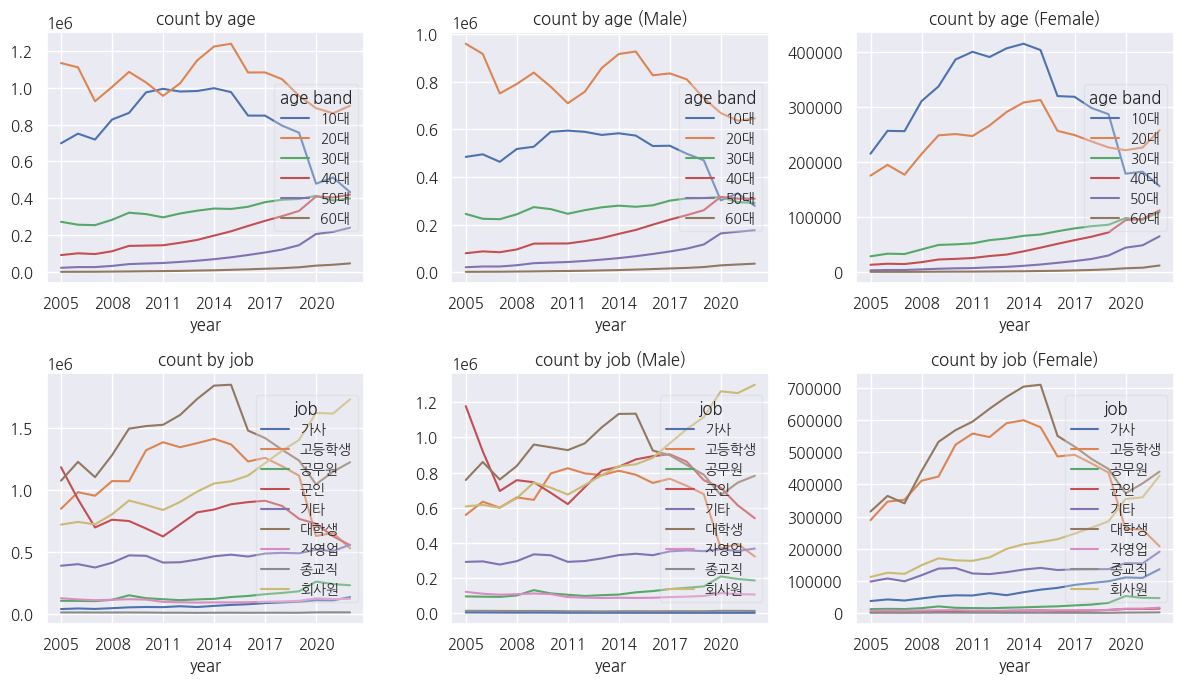

In [811]:
# 연령별 헌혈통계
_, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 7))

age_group = bd_age_df.groupby(by=["year", "age_band"])["count"].sum().unstack()
age_group.plot.line(title="count by age", ax=axs[0, 0])

age_group = bd_age_df.groupby(by=["year", "age_band", "gender"])["count"].sum()
age_group.xs("남", level="gender").unstack().plot.line(title="count by age (Male)", ax=axs[0, 1])
age_group.xs("여", level="gender").unstack().plot.line(title="count by age (Female)", ax=axs[0][2])

for ax in axs[0]:
    ax.legend(title='age band', loc=5, fontsize=10, framealpha=0.3)

# 직업별 헌혈통계
age_group = bd_job_df.groupby(by=["year", "job"])["count"].sum().unstack()
age_group.plot.line(title="count by job", ax=axs[1, 0])

age_group = bd_job_df.groupby(by=["year", "job", "gender"])["count"].sum()
age_group.xs("남", level="gender").unstack().plot.line(title="count by job (Male)", ax=axs[1, 1])
age_group.xs("여", level="gender").unstack().plot.line(title="count by job (Female)", ax=axs[1, 2])

for ax in axs.flatten():
    ax.set_xticks(range(2005, 2022 + 1, 3))
for ax in axs[1]:
    ax.legend(title='job', loc=5, fontsize=10, framealpha=0.3)

plt.tight_layout()
plt.show()

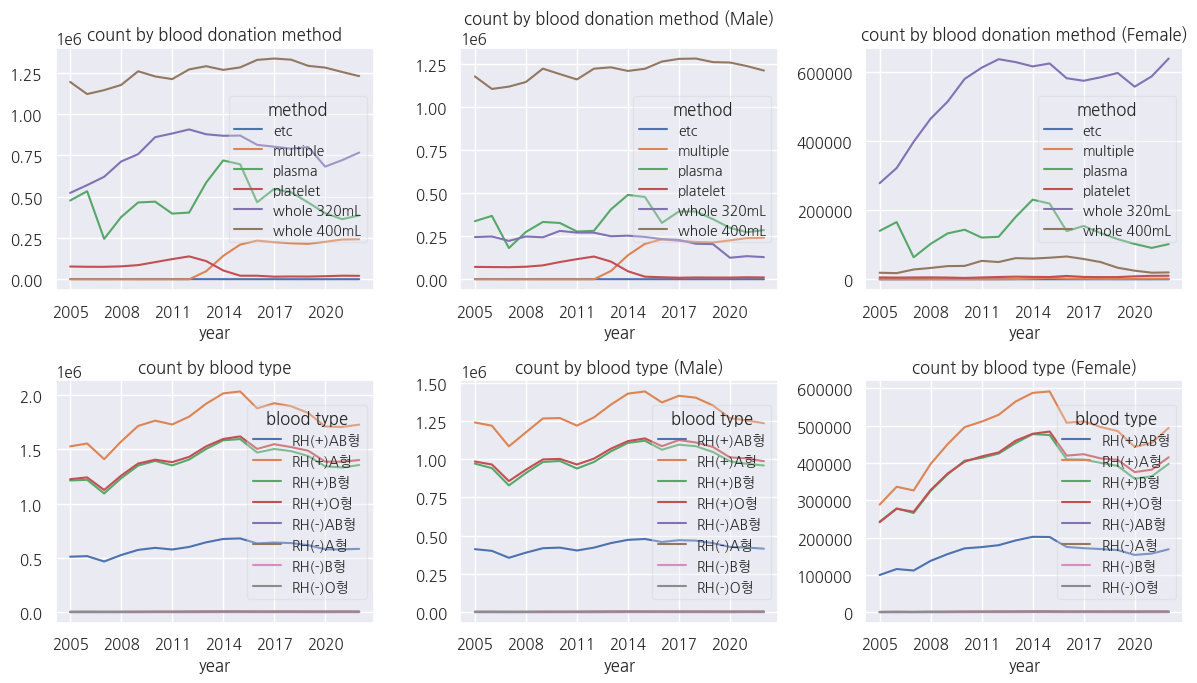

In [812]:
# 헌혈방법별 혈액통계
_, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 7))

method_group = bd_method_df.groupby(by=["year", "method"])["count"].sum().unstack()
method_group.plot.line(title="count by blood donation method", ax=axs[0, 0])

method_group = bd_method_df.groupby(by=["year", "method", "gender"])["count"].sum()
method_group.xs("남", level="gender").unstack().plot.line(title="count by blood donation method (Male)", ax=axs[0, 1])
method_group.xs("여", level="gender").unstack().plot.line(title="count by blood donation method (Female)", ax=axs[0, 2])

for ax in axs[0]:
    ax.legend(title='method', loc=5, fontsize=10, framealpha=0.3)

# 혈액형별 헌혈통계
method_group = bd_btype_df.groupby(by=["year", "type"])["count"].sum().unstack()
method_group.plot.line(title="count by blood type", ax=axs[1, 0])

method_group = bd_btype_df.groupby(by=["year", "type", "gender"])["count"].sum()
method_group.xs("남", level="gender").unstack().plot.line(title="count by blood type (Male)", ax=axs[1, 1])
method_group.xs("여", level="gender").unstack().plot.line(title="count by blood type (Female)", ax=axs[1, 2])

for ax in axs.flatten():
    ax.set_xticks(range(2005, 2022 + 1, 3))
for ax in axs[1]:
    ax.legend(title='blood type', loc=5, fontsize=10, framealpha=0.3)

plt.tight_layout()
plt.show()

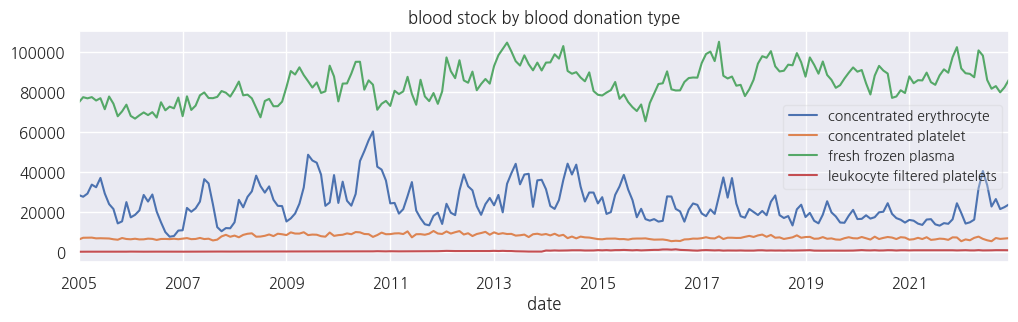

In [813]:
_, ax = plt.subplots(figsize=(12, 3))
bs_group = bs_month_type_df.groupby(by=["date", "type"])["count"].sum().unstack()
bs_group.plot.line(title="blood stock by blood donation type", ax=ax)
ax.legend(loc=5, fontsize=10, framealpha=0.3)
plt.show()

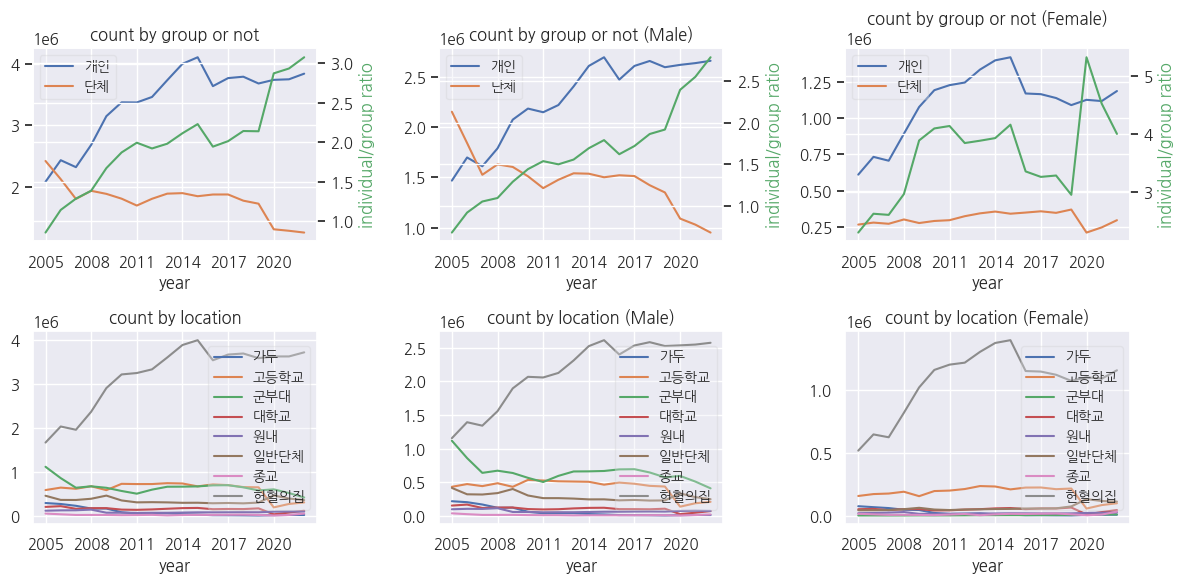

In [814]:
_, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

# 장소별 헌혈통계
# 단체여부
location_group = bd_location_df.groupby(by=["year", "group"])["count"].sum().unstack()
location_group.plot.line(title="count by group or not", ax=axs[0, 0])
ax = axs[0, 0].twinx()
ax.plot(location_group["개인"]/location_group["단체"], c="C2")
ax.set_ylabel("individual/group ratio", color="C2")

location_group = bd_location_df.groupby(by=["year", "group", "gender"])["count"].sum()
male_series = location_group.xs("남", level="gender").unstack()
male_series.plot.line(title="count by group or not (Male)", ax=axs[0, 1])
ax = axs[0, 1].twinx()
ax.plot(male_series["개인"]/male_series["단체"], c="C2")
ax.set_ylabel("individual/group ratio", color="C2")

female_series = location_group.xs("여", level="gender").unstack()
female_series.plot.line(title="count by group or not (Female)", ax=axs[0, 2])
ax = axs[0, 2].twinx()
ax.plot(female_series["개인"]/female_series["단체"], c="C2")
ax.set_ylabel("individual/group ratio", color="C2")

# 장소
location_group = bd_location_df.groupby(by=["year", "location"])["count"].sum().unstack()
location_group.plot.line(title="count by location", ax=axs[1, 0])

location_group = bd_location_df.groupby(by=["year", "location", "gender"])["count"].sum()
location_group.xs("남", level="gender").unstack().plot.line(title="count by location (Male)", ax=axs[1, 1])
location_group.xs("여", level="gender").unstack().plot.line(title="count by location (Female)", ax=axs[1, 2])

for i, ax in enumerate(axs.flatten()):
    ax.set_xticks(range(2005, 2022 + 1, 3))
    if i<3:
        ax.legend(loc=2, fontsize=10, framealpha=0.3)
    else:
        ax.legend(loc=5, fontsize=10, framealpha=0.3)

plt.tight_layout()
plt.show()

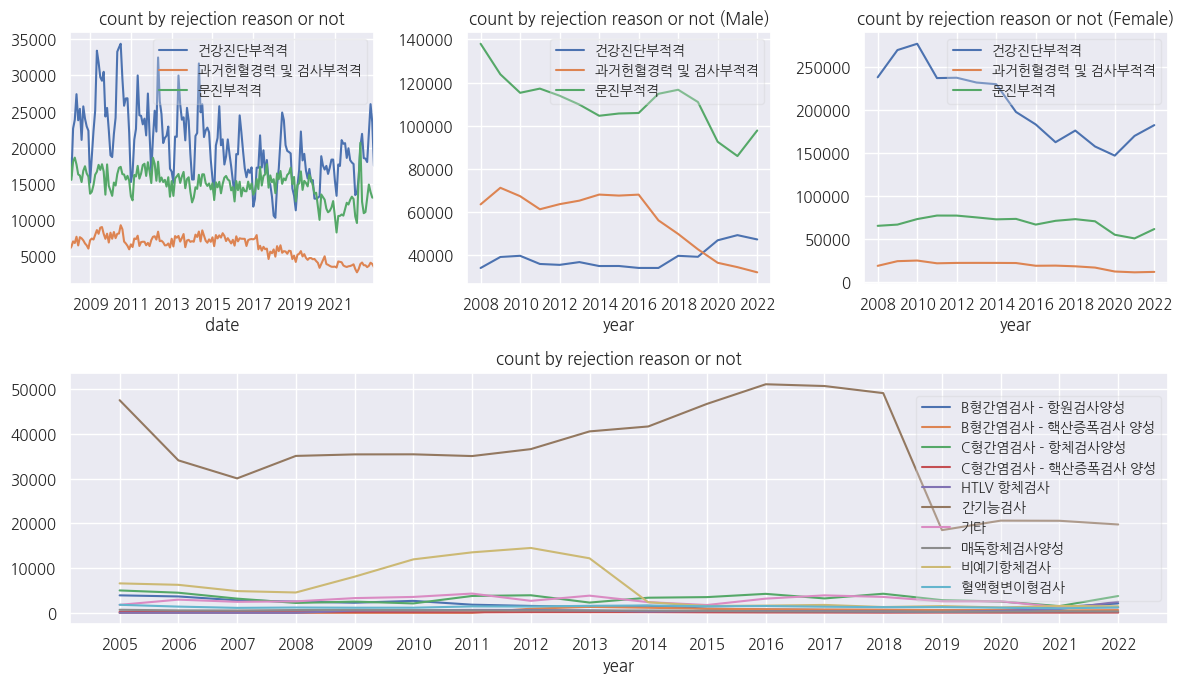

In [817]:
fig = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[1, 1])

# 사유별 헌혈 부적격
axs = [fig.add_subplot(gs[0, i]) for i in range(3)]
rejection_group = rejection_reason_month_df.groupby(by=["date", "reason"])["count"].sum().unstack()
rejection_group.plot.line(title="count by rejection reason or not", ax=axs[0])

rejection_group = rejection_reason_gender_df.groupby(by=["year", "reason", "gender"])["count"].sum()
rejection_group.xs("남", level="gender").unstack().plot.line(title="count by rejection reason or not (Male)", ax=axs[1])
rejection_group.xs("여", level="gender").unstack().plot.line(title="count by rejection reason or not (Female)", ax=axs[2])

for i, ax in enumerate(axs):
    ax.legend(loc=1, fontsize=10, framealpha=0.3)
    if i > 0:
        ax.set_xticks(range(2008, 2022 + 1, 2))

# 혈액검사 부적격
ax = fig.add_subplot(gs[1, :])
test_fail_group = test_fail_df[test_fail_df["reason"] != "검사 부적격"].groupby(by=["year", "reason"])["count"].sum().unstack()
test_fail_group.plot.line(title="count by rejection reason or not", ax=ax)
ax.legend(loc=5, fontsize=10, framealpha=0.3)
ax.set_xticks(range(2005, 2022 + 1))
plt.tight_layout()
plt.show()
# 얘도 계절적 요소 있어보임. 겨울 -> 감기